# Trading Strategies powered by Machine Learning - Support Vector Regression

## Support Vector Classifier with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv
pd.options.mode.chained_assignment = None  # default=

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


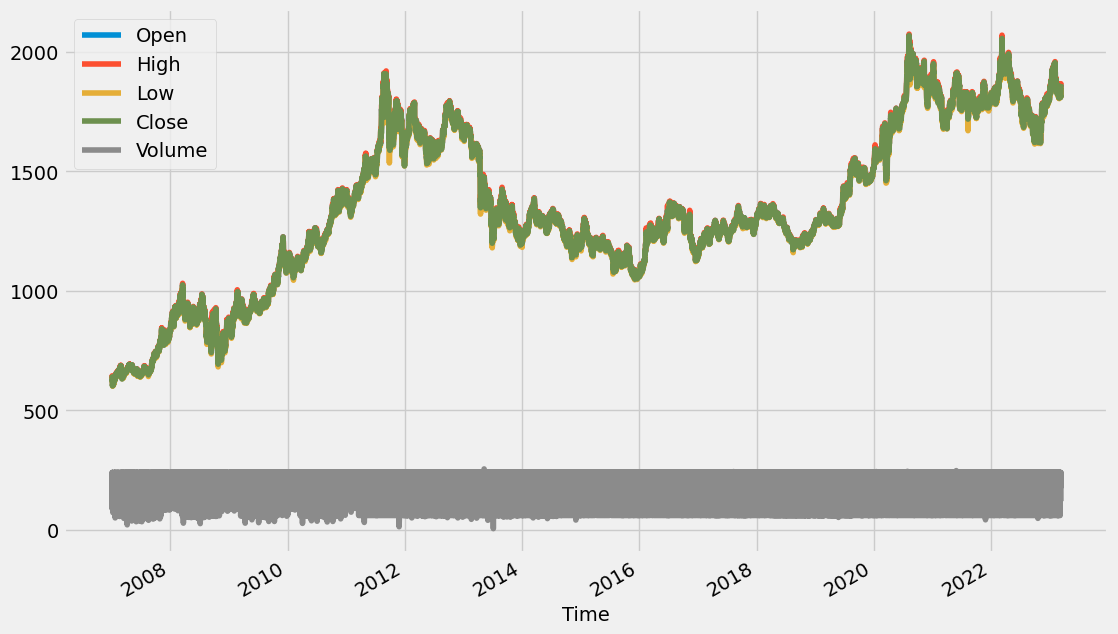

In [8]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Support_Vector_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [10]:
strategy = Support_Vector_Regression
account_size = 1000
folder_ML_Strategy = 'Support Vector Regression'

In [11]:
from sklearn.svm import SVR
from backtesting import Backtest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8")


class ML_SVR():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, future_days=1):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.future_days = future_days

    def Train_Model(self):
        df = self.data.copy()

        df[str(self.future_days) +
           '_Day_Price_Forecast'] = df['Close'].shift(-self.future_days)

        # Drop rows with NaN in the newly created column
        df.dropna(subset=[str(self.future_days) +
                  '_Day_Price_Forecast'], inplace=True)

        # Features (Close price as input)
        X = df[['Close']].copy()  # Corrected X to be a DataFrame
        Y = df[str(self.future_days) + '_Day_Price_Forecast'].copy()  # Target

        # Split data into train and test
        self.data_train = df.loc[self.start_train:self.end_train].copy()
        self.data_test = df.loc[self.start_test:self.end_test].copy()

        x_train = self.data_train[['Close']]
        y_train = Y.loc[self.start_train:self.end_train]
        x_test = self.data_test[['Close']]

        # Initialize and train the SVR model
        self.model = SVR(kernel='rbf', C=1e3, gamma=0.00001)
        self.model.fit(x_train, y_train)  # Removed unnecessary indexing

        # Make predictions
        self.data_train['Close_pred'] = self.model.predict(x_train)
        self.data_test['Close_pred'] = self.model.predict(x_test)

    def Add_Signal(self):

        self.data_train['pred'] = np.where(
            (self.data_train['Close_pred'] > self.data_train['Close']), 1, -1)
        self.data_test['pred'] = np.where(
            (self.data_test['Close_pred'] > self.data_test['Close']), 1, -1)

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result

    def Run(self):
        self.Train_Model()
        self.Add_Signal()

        result_train = self.Backtest(self.data_train)
        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [12]:
ML_Class = ML_SVR

## TF D1

In [13]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [14]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [15]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [16]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                     2666.241
Equity Peak [$]                      2848.586
Return [%]                           166.6241
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    6.288757
Volatility (Ann.) [%]               10.359743
Sharpe Ratio                         0.607038
Sortino Ratio                        0.937906
Calmar Ratio                         0.278012
Max. Drawdown [%]                  -22.620486
Avg. Drawdown [%]                   -1.614908
Max. Drawdown Duration     2570 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                   53
Win Rate [%]                         84.90566
Best Trade [%]                      147.95666
Worst Trade [%]                    -10.715172
Avg. Trade [%]                    

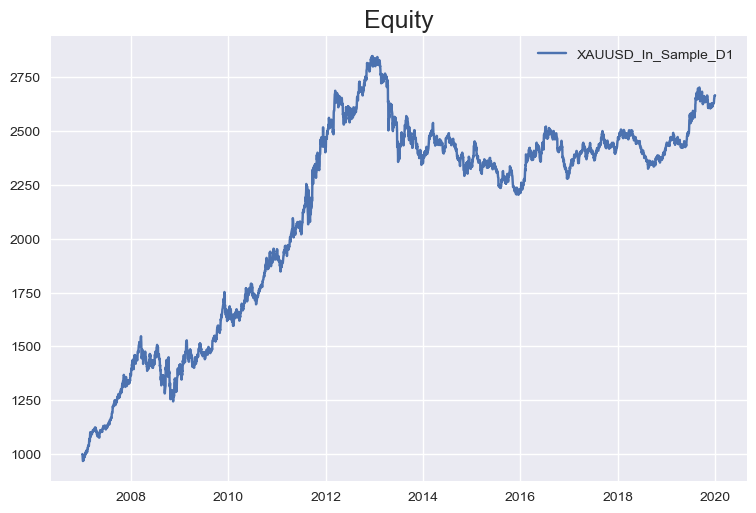

In [17]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [18]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     1673.633
Equity Peak [$]                       1782.48
Return [%]                            67.3633
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                   14.007047
Volatility (Ann.) [%]               23.151169
Sharpe Ratio                         0.605025
Sortino Ratio                         1.11775
Calmar Ratio                         0.585112
Max. Drawdown [%]                  -23.939074
Avg. Drawdown [%]                   -5.052068
Max. Drawdown Duration      476 days 00:00:00
Avg. Drawdown Duration       49 days 00:00:00
# Trades                                   30
Win Rate [%]                        96.666667
Best Trade [%]                       12.31743
Worst Trade [%]                      -6.06814
Avg. Trade [%]                    

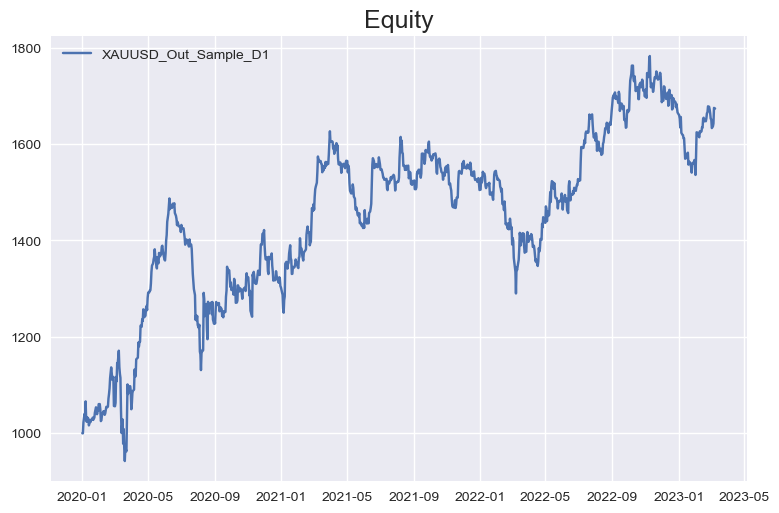

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [25]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [26]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [27]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                     1826.084
Equity Peak [$]                      2248.354
Return [%]                            82.6084
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                    3.814967
Volatility (Ann.) [%]               12.360018
Sharpe Ratio                         0.308654
Sortino Ratio                         0.45872
Calmar Ratio                         0.111175
Max. Drawdown [%]                  -34.315014
Avg. Drawdown [%]                   -1.456413
Max. Drawdown Duration     2993 days 12:00:00
Avg. Drawdown Duration       29 days 06:00:00
# Trades                                  363
Win Rate [%]                        52.341598
Best Trade [%]                      81.717056
Worst Trade [%]                    -20.832706
Avg. Trade [%]                    

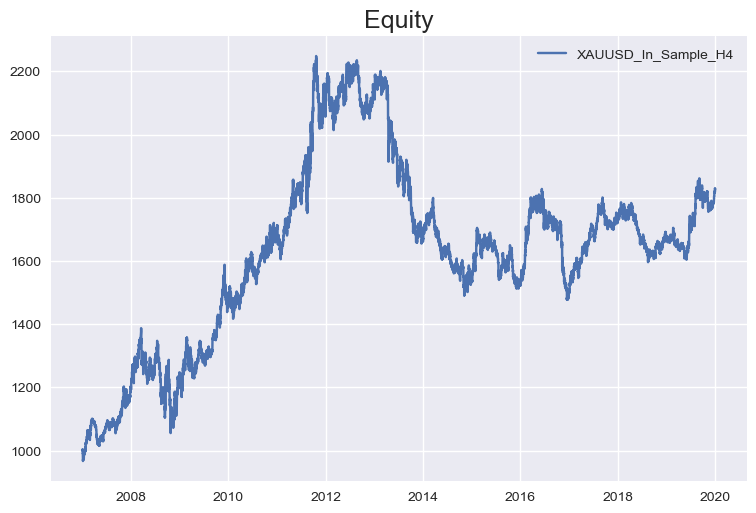

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                     1443.826
Equity Peak [$]                      1532.923
Return [%]                            44.3826
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                    9.790006
Volatility (Ann.) [%]               25.598459
Sharpe Ratio                         0.382445
Sortino Ratio                        0.664885
Calmar Ratio                         0.371148
Max. Drawdown [%]                  -26.377643
Avg. Drawdown [%]                   -2.878439
Max. Drawdown Duration      361 days 20:00:00
Avg. Drawdown Duration       22 days 15:00:00
# Trades                                  167
Win Rate [%]                        64.071856
Best Trade [%]                       8.088668
Worst Trade [%]                      -7.43569
Avg. Trade [%]                    

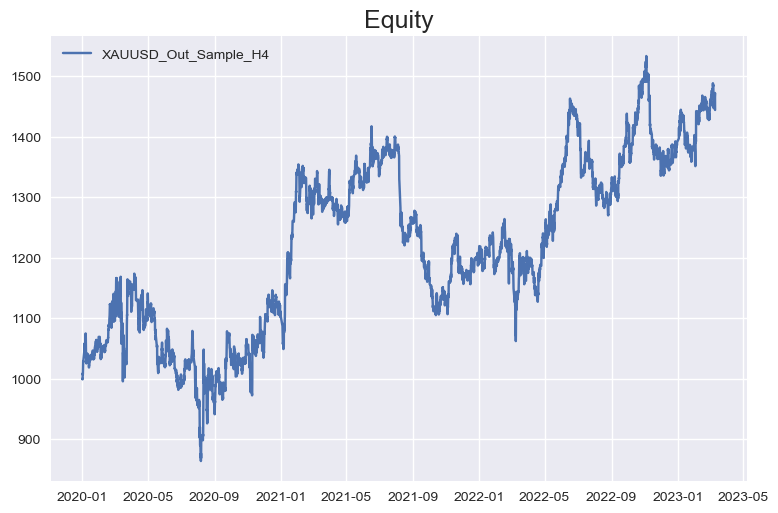

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [36]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [37]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [38]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                     2149.929
Equity Peak [$]                      2187.736
Return [%]                           114.9929
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                    4.871776
Volatility (Ann.) [%]               13.135598
Sharpe Ratio                         0.370883
Sortino Ratio                        0.561071
Calmar Ratio                         0.186055
Max. Drawdown [%]                  -26.184569
Avg. Drawdown [%]                   -0.970621
Max. Drawdown Duration     1134 days 09:00:00
Avg. Drawdown Duration       14 days 21:00:00
# Trades                                  749
Win Rate [%]                        56.074766
Best Trade [%]                      85.382256
Worst Trade [%]                    -19.361637
Avg. Trade [%]                    

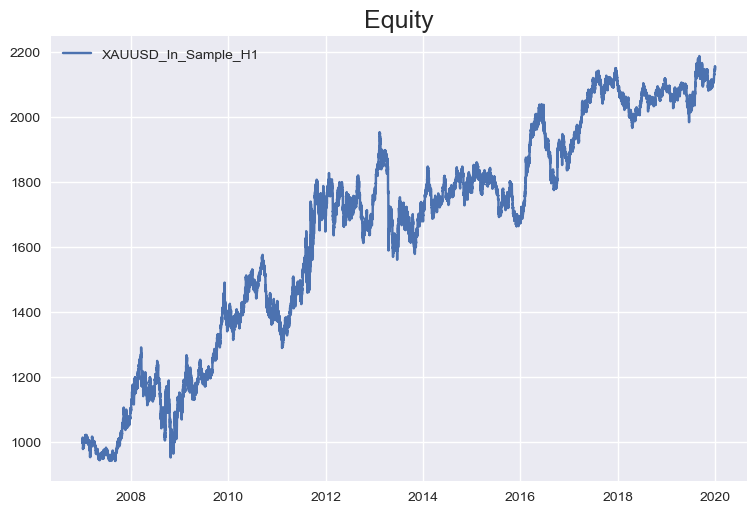

In [39]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [40]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                     1441.604
Equity Peak [$]                      1544.463
Return [%]                            44.1604
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                    9.747016
Volatility (Ann.) [%]               24.893034
Sharpe Ratio                         0.391556
Sortino Ratio                        0.668937
Calmar Ratio                         0.258268
Max. Drawdown [%]                  -37.739978
Avg. Drawdown [%]                   -1.741424
Max. Drawdown Duration      770 days 03:00:00
Avg. Drawdown Duration       13 days 08:00:00
# Trades                                  413
Win Rate [%]                        46.731235
Best Trade [%]                      10.132325
Worst Trade [%]                      -6.57529
Avg. Trade [%]                    

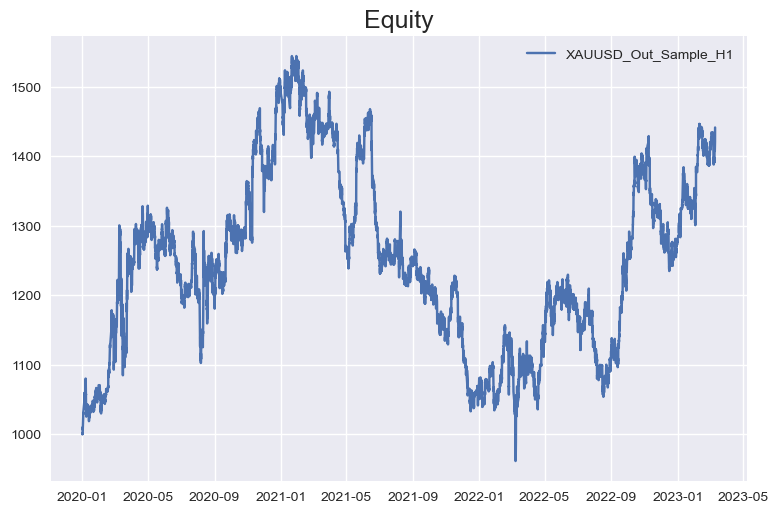

In [41]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [42]:
filename_train = f'result_{TF}_In_Sample.csv'

In [43]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [44]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [45]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [46]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [47]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [48]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [49]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                     1572.053
Equity Peak [$]                      1639.835
Return [%]                            57.2053
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                    2.852368
Volatility (Ann.) [%]               16.615514
Sharpe Ratio                         0.171669
Sortino Ratio                        0.250711
Calmar Ratio                         0.056782
Max. Drawdown [%]                  -50.233774
Avg. Drawdown [%]                   -0.955567
Max. Drawdown Duration     3415 days 13:30:00
Avg. Drawdown Duration       21 days 20:25:00
# Trades                                 1443
Win Rate [%]                         49.96535
Best Trade [%]                       83.74448
Worst Trade [%]                    -11.709234
Avg. Trade [%]                    

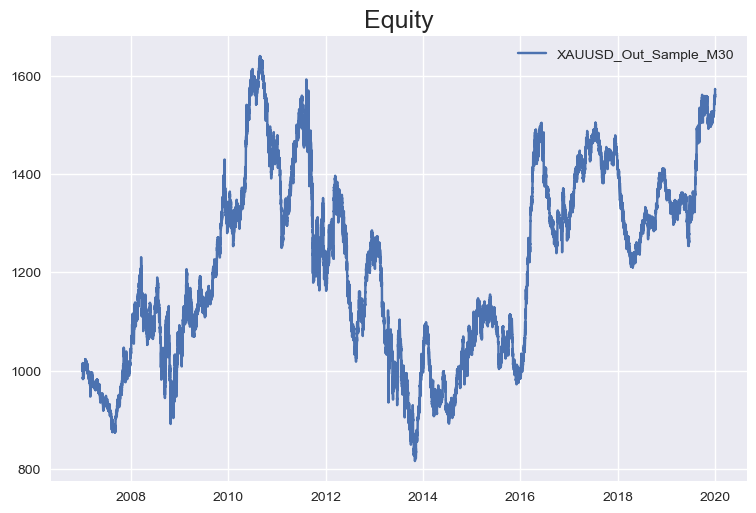

In [50]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [51]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1102.988
Equity Peak [$]                       1584.69
Return [%]                            10.2988
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                    2.523935
Volatility (Ann.) [%]               24.519071
Sharpe Ratio                         0.102938
Sortino Ratio                        0.159181
Calmar Ratio                         0.053246
Max. Drawdown [%]                  -47.401637
Avg. Drawdown [%]                   -1.597747
Max. Drawdown Duration      778 days 11:30:00
Avg. Drawdown Duration        8 days 23:54:00
# Trades                                  677
Win Rate [%]                         48.59675
Best Trade [%]                       7.170862
Worst Trade [%]                     -5.451641
Avg. Trade [%]                    

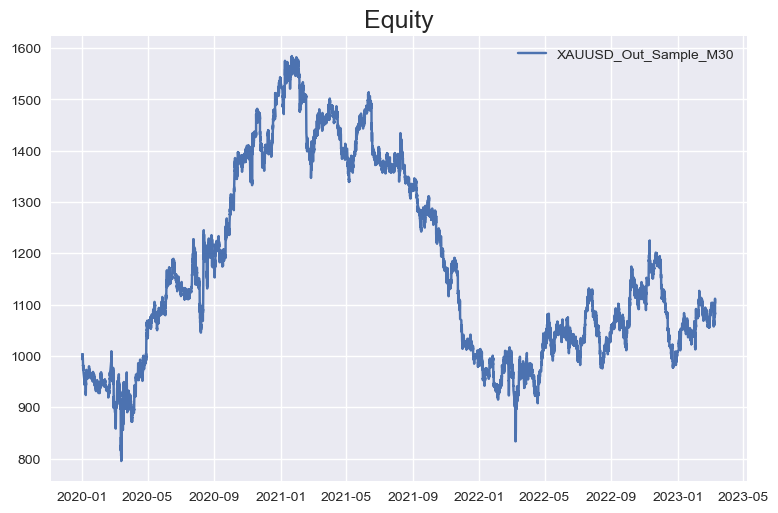

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [53]:
filename_train = f'result_{TF}_In_Sample.csv'

In [54]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [55]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [56]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [57]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [58]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [59]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_304\2307814005.py:66: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [60]:
train

Start                     2014-09-23 13:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 08:45:00
Exposure Time [%]                   99.998394
Equity Final [$]                     1477.673
Equity Peak [$]                       1660.78
Return [%]                            47.7673
Buy & Hold Return [%]                23.74151
Return (Ann.) [%]                    6.103855
Volatility (Ann.) [%]               11.639874
Sharpe Ratio                         0.524392
Sortino Ratio                        0.833635
Calmar Ratio                         0.321526
Max. Drawdown [%]                  -18.984032
Avg. Drawdown [%]                    -0.59004
Max. Drawdown Duration      530 days 07:00:00
Avg. Drawdown Duration        5 days 05:11:00
# Trades                                 1548
Win Rate [%]                        60.335917
Best Trade [%]                       7.665643
Worst Trade [%]                     -9.461659
Avg. Trade [%]                    

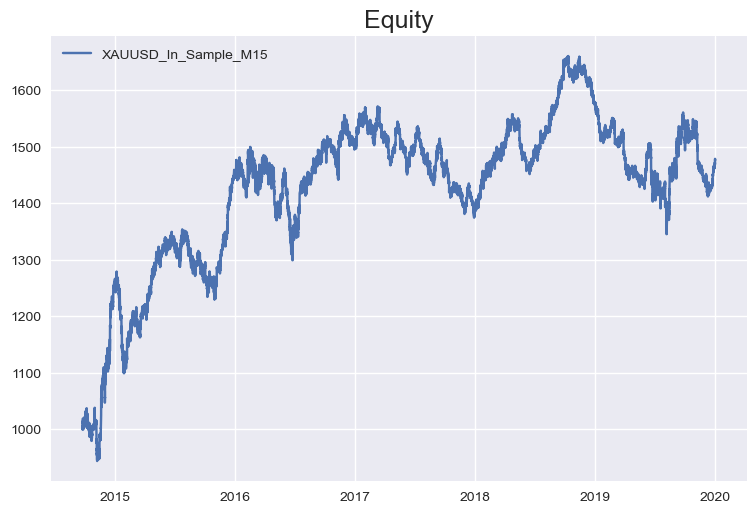

In [61]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [62]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                      714.996
Equity Peak [$]                      1063.045
Return [%]                           -28.5004
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                   -8.207486
Volatility (Ann.) [%]               34.555675
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -52.267684
Avg. Drawdown [%]                   -9.532786
Max. Drawdown Duration     1089 days 07:30:00
Avg. Drawdown Duration      145 days 10:45:00
# Trades                                   21
Win Rate [%]                        76.190476
Best Trade [%]                       4.294472
Worst Trade [%]                    -21.866748
Avg. Trade [%]                    

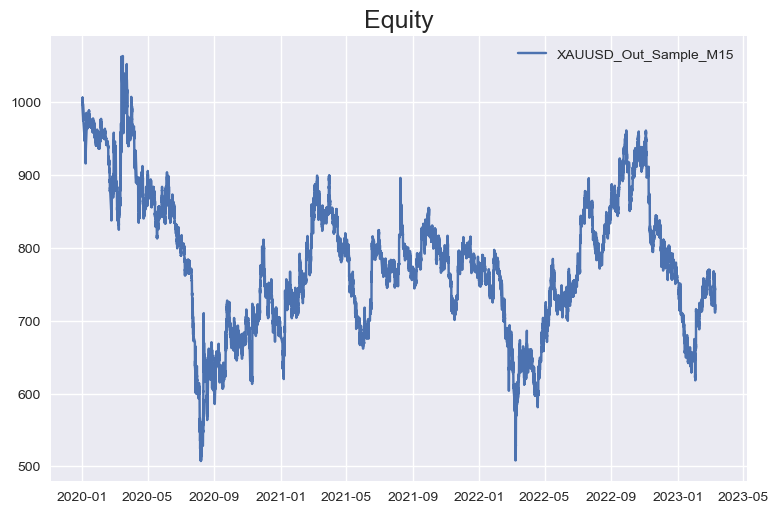

In [63]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [64]:
filename_train = f'result_{TF}_In_Sample.csv'

In [65]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [66]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [67]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [68]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [69]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [70]:
train, test = ml.Run()

: 

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [ ]:
train, test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')